In [619]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import json
import statsmodels.api as sm
from scipy import stats
from sklearn import linear_model
from sklearn.neighbors import BallTree
from sklearn.ensemble import GradientBoostingClassifier
import random
import networkx as nx
from sklearn.metrics import fbeta_score, make_scorer

%matplotlib inline
datapath = "C:\\sandy\\3insurance\\data\\" # data file path

In [181]:
# import data
df = pd.read_csv(datapath+'train.csv',sep = ",", low_memory=False) # master table name
df = df.fillna(0)
df_numeric = df.copy()
for ci in df.columns:
    p_order = sorted(list(set(df[ci])))
    if isinstance(p_order[0], str):
        df_numeric[ci] = df_numeric[ci].replace(p_order, range(len(p_order)))

69


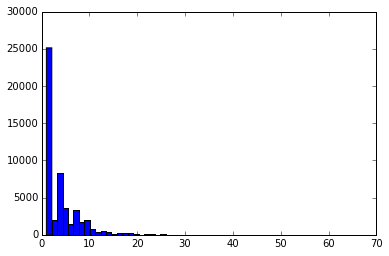

In [32]:
# hazard distribution
print max(df_numeric["Hazard"])
plt.hist(df_numeric["Hazard"], bins = 60)
plt.show()

In [35]:
df_numeric.columns

Index([u'Id', u'Hazard', u'T1_V1', u'T1_V2', u'T1_V3', u'T1_V4', u'T1_V5',
       u'T1_V6', u'T1_V7', u'T1_V8', u'T1_V9', u'T1_V10', u'T1_V11', u'T1_V12',
       u'T1_V13', u'T1_V14', u'T1_V15', u'T1_V16', u'T1_V17', u'T2_V1',
       u'T2_V2', u'T2_V3', u'T2_V4', u'T2_V5', u'T2_V6', u'T2_V7', u'T2_V8',
       u'T2_V9', u'T2_V10', u'T2_V11', u'T2_V12', u'T2_V13', u'T2_V14',
       u'T2_V15'],
      dtype='object')

46282
4717
46282
4717
46282
4717
46282
4717
46282
4717
46282
4717
46282
4717
46282
4717
46282
4717
46282
4717
46282
4717
46282
4717
46282
4717
46282
4717
46282
4717
46282
4717
46282
4717
46282
4717
46282
4717
46282
4717
46282
4717
46282
4717
46282
4717
46282
4717
46282
4717
46282
4717
46282
4717
46282
4717
46282
4717
46282
4717
46282
4717
46282
4717
46282
4717


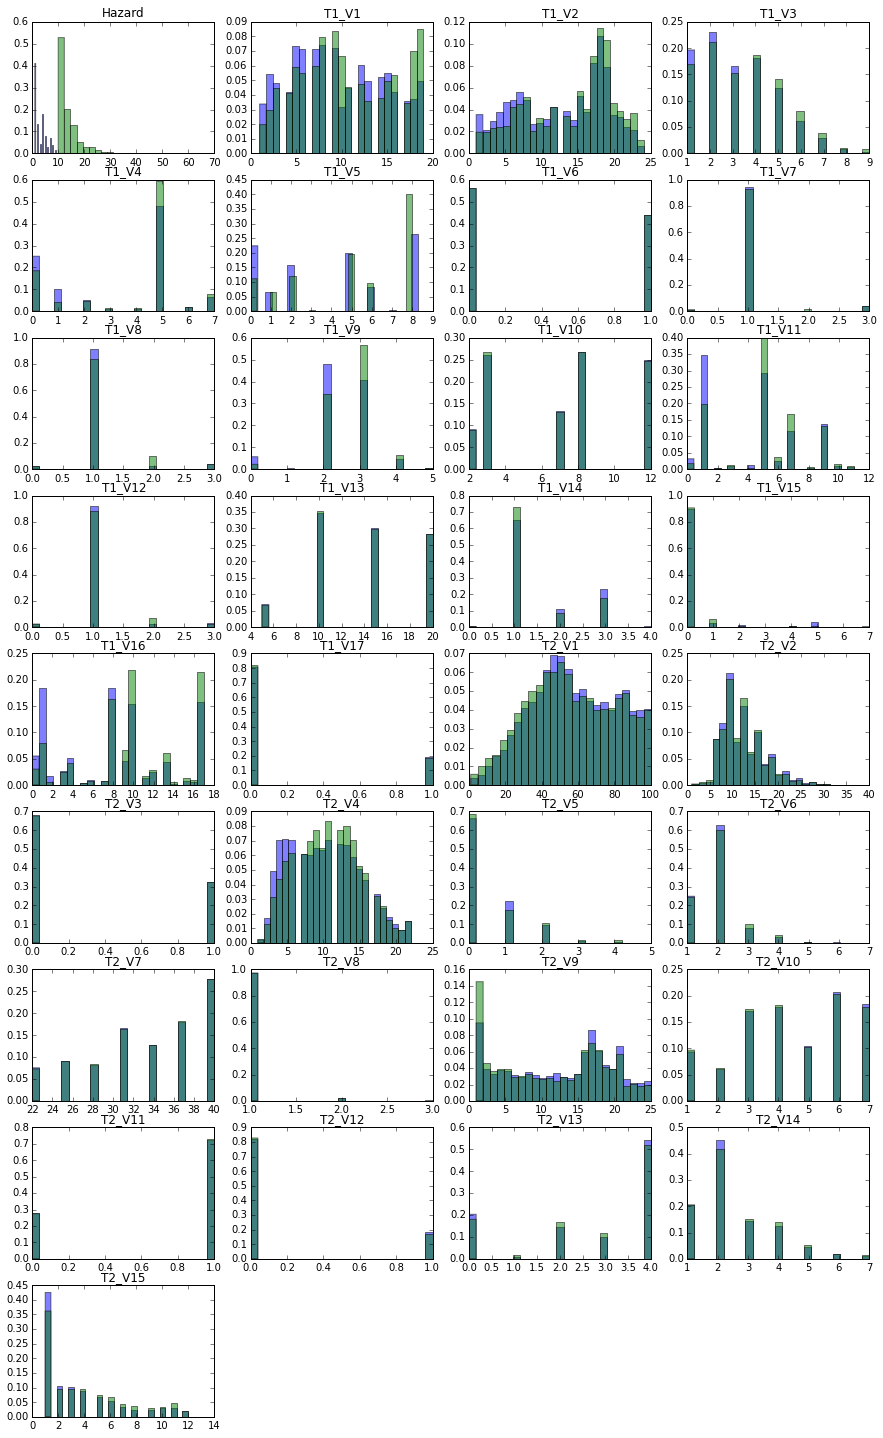

In [222]:
# group by hazard (feature comparison)
bounds = [0,10,70]
plt.figure(figsize=(15,25))
for fi in range(1,len(df_numeric.columns)):
    plt.subplot(9,4,fi)
    fi_name = df_numeric.columns[fi]
    for i in range(len(bounds)-1):
        groupdata = df_numeric[(df_numeric["Hazard"]>=bounds[i]) & (df_numeric["Hazard"]<bounds[i+1])]
        print len(groupdata)
        weights = np.ones_like(list(groupdata[fi_name]))/float(len(groupdata[fi_name]))
        plt.hist(list(groupdata[fi_name]), bins = 25, weights = weights, alpha=0.5)
#    plt.legend()
    plt.title(fi_name)
plt.show()

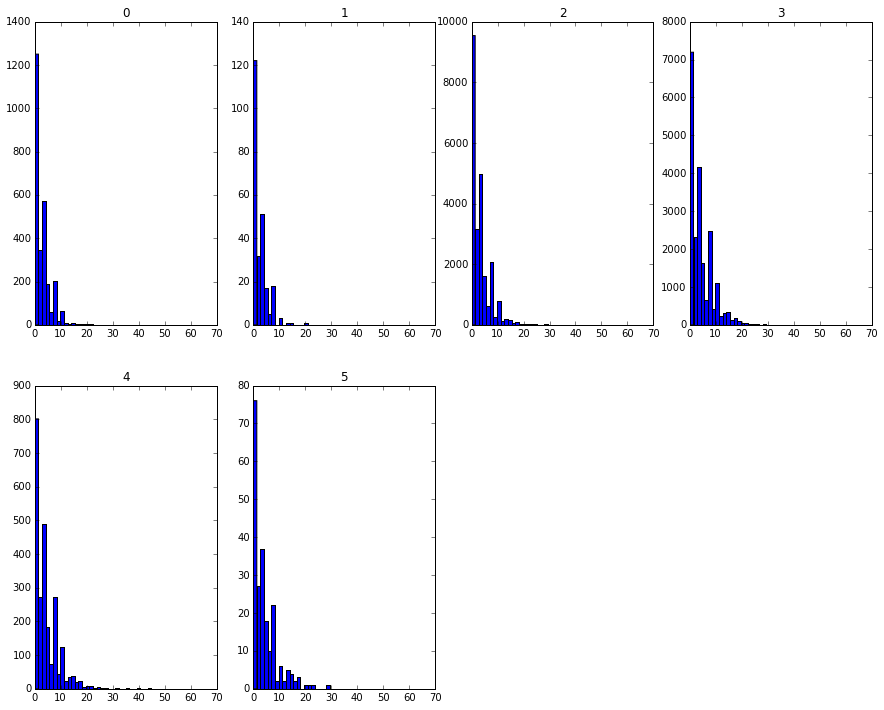

In [280]:
# hazard distribution for deferent feature group
selected_feature = "T1_V9"
g = df_numeric.groupby(selected_feature)["Hazard"]
count = 0
plt.figure(figsize=(15,25))
for ni, gi in g:
    plt.subplot(4,4,count+1)
    plt.hist(list(gi), bins = 50, range = (0,70))
    plt.title(ni)
    count += 1
plt.show()

T1_V1 : 0.0461342478602
T1_V2 : 0.0960196411071
T1_V3 : 0.0627882278495
T1_V4 : 0.0472822317797
T1_V5 : 0.00449335459881
T1_V9 : -0.0078552903027
T1_V10 : 0.0131828773229
T1_V13 : -0.0066727000801
T1_V14 : -0.0530220534367
T1_V16 : 0.0275693531053
T2_V1 : -0.0179869497199
T2_V2 : -0.0186919310199
T2_V4 : 0.00165718319313
T2_V6 : 0.0294525792738
T2_V7 : 0.00749356500644
T2_V8 : 0.0029644751321
T2_V9 : -0.0598932356188
T2_V10 : -0.0190412646134
T2_V14 : 0.0372005497557
T2_V15 : 0.0486929303155


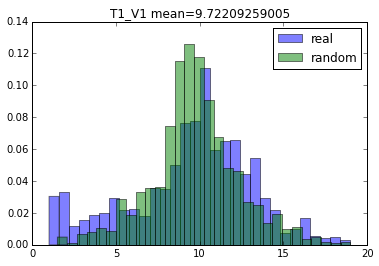

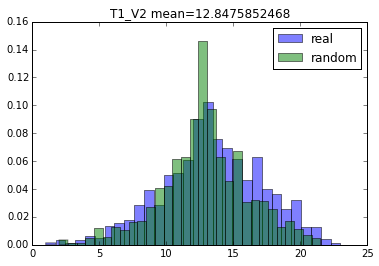

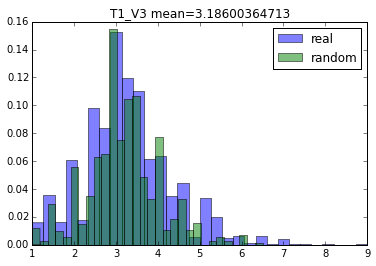

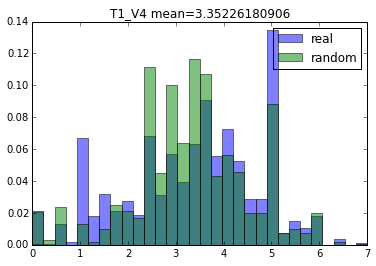

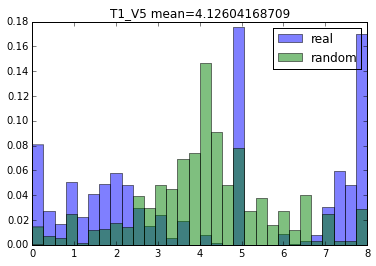

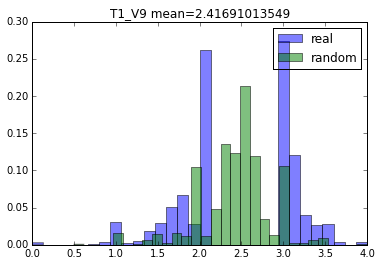

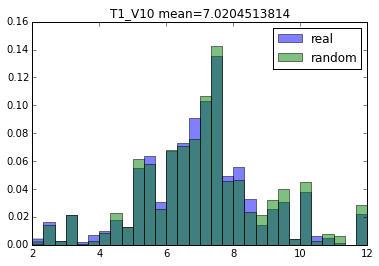

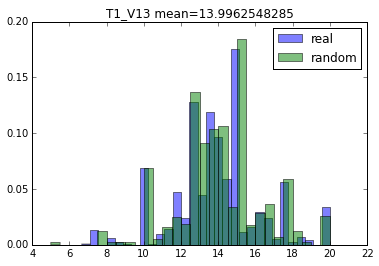

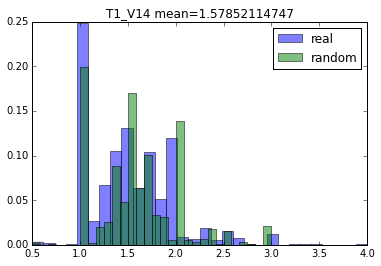

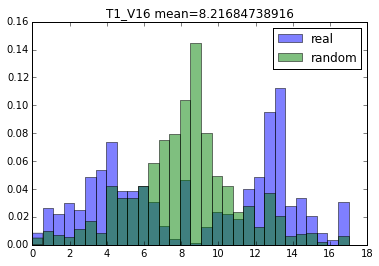

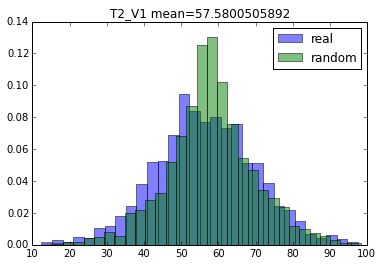

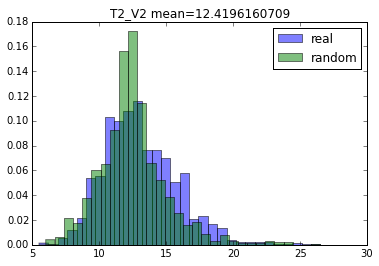

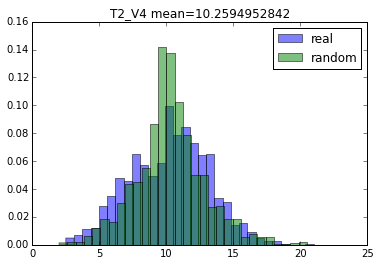

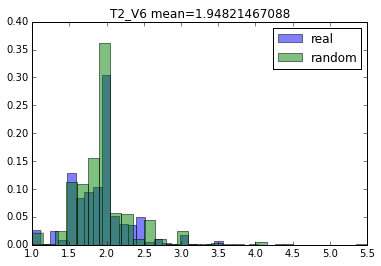

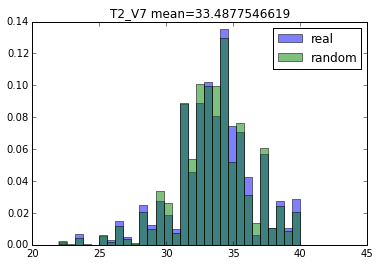

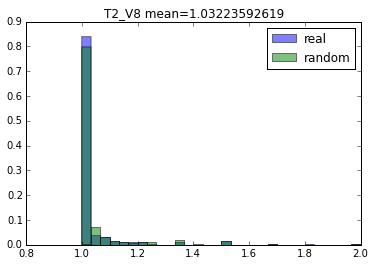

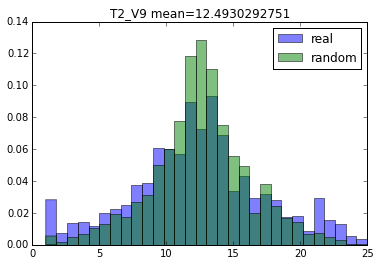

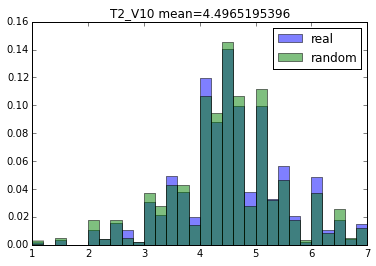

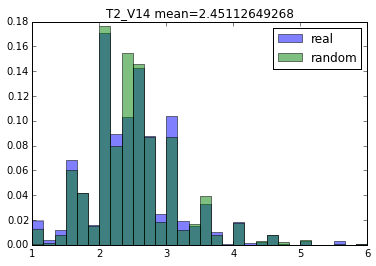

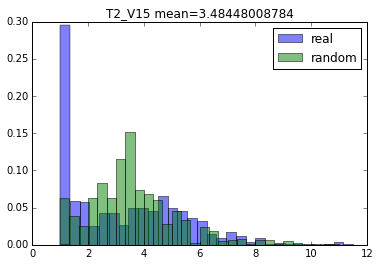

In [368]:
# feature corelation in deferent feature group
feature_group = [ 'T1_V7', 'T1_V8', 'T1_V11', 'T1_V12', 'T1_V15', 'T2_V5', 'T2_V13']
feature_select = ['T1_V1', 'T1_V2', 'T1_V3','T1_V4', 'T1_V5', 'T1_V9','T1_V10', 'T1_V13', 'T1_V14','T1_V16', 'T2_V1', 
                 'T2_V2', 'T2_V4', 'T2_V6', 'T2_V7', 'T2_V8', 'T2_V9', 'T2_V10', 'T2_V14', 'T2_V15']
count = 0
#plt.figure(figsize=(15,25))
g = df_numeric.groupby(feature_group)
for fi in feature_select:
    #print count
    corrs = []
    x_mean = []
    x_mean_random = []
    for ni, gi in g:
        x = gi[fi]
        y = gi["Hazard"]
        if len(x) >= 2:
            x_mean.append(np.array(x).mean())
            x_mean_random.append(np.array(random.sample(df_numeric[fi], len(gi))).mean())
        corrs.append(x.corr(y, method='spearman', min_periods=5))
    corrs = [x for x in corrs if not math.isnan(x)]
    print fi, ":", np.array(corrs).mean()
    plt.figure()
    w1 = np.ones_like(x_mean)/float(len(x_mean))
    w2 = np.ones_like(x_mean_random)/float(len(x_mean_random))
    plt.hist(x_mean,bins=30, weights = w1, alpha = 0.5, label = "real")
    plt.hist(x_mean_random,bins=30, weights = w2, alpha = 0.5, label = "random")
    #plt.subplot(4,4,count+1)
    #plt.hist(corrs,bins = 20)
    plt.title(fi+" mean="+str(df_numeric[fi].mean()))
    plt.legend()
    count += 1
plt.show()

In [282]:
# property similarity
simi = {}
for i in range(len(df_numeric)):
    if i%100 == 0:
        print i
    for j in range(i,len(df_numeric)):
        xx = [float(x) for x in df_numeric.max()[2:]] 
        idata = np.array(df_numeric.iloc[i][2:])/ xx
        jdata = np.array(df_numeric.iloc[j][2:])/ xx 
        name = str(df_numeric.iloc[i]["Id"])+"+"+str(df_numeric.iloc[j]["Id"])
        simi[name] = idata.dot(jdata) / (np.sqrt(idata.dot(idata)) * np.sqrt(jdata.dot(jdata)))

0


KeyboardInterrupt: 

In [1241]:
# get costomer features
feature_group = ['T1_V4','T1_V5','T1_V6', 'T1_V7', 'T1_V8','T1_V9', 'T1_V11', 'T1_V12', 'T1_V15', 'T1_V16','T1_V17','T2_V3','T2_V5',
                 'T2_V11','T2_V12','T2_V13']
feature_select = ['T1_V1', 'T1_V2', 'T1_V3','T1_V10', 'T1_V13', 'T1_V14', 'T2_V1', 
                 'T2_V2', 'T2_V4', 'T2_V6', 'T2_V7', 'T2_V8', 'T2_V9', 'T2_V10', 'T2_V14', 'T2_V15']
print 'here'
# features about the group (means of group features, feature rank in the group)
def get_more_features1(df_numeric_new,df_numeric, f_group, f_select):
    g = df_numeric.groupby(f_group)
    for fi in f_select:
        print fi
        s_name1 = 'C_'+fi
        s1 = pd.Series([], name=s_name1)
        df_numeric_new = pd.concat([df_numeric_new,s1], axis=1)
    
    count = 0
    for ni, gi in g:
        count += 1
        if count%100==0:
            print count, "/", len(g)
        for fi in f_select:
            f_mean = np.array(gi[fi]).mean()
            s_name1 = 'C_'+fi
            for ii in gi.index:
                df_numeric_new.loc[ii,s_name1] = f_mean
    return df_numeric_new

# featrues generate by nearest neighbors
def distance_to_each_class(df_numeric, neighborsN):
    df_numeric_new = df_numeric.copy()
    class_dta = {}
    for i in set(df_numeric['Hazard']):
        class_dta[i] = df_numeric[df_numeric['Hazard']==i].drop(['Id','Hazard'], axis=1).as_matrix()
        for ni in neighborsN:
            s_name1 = 'Dist_C_'+str(i)+'_N'+str(ni)
            s1 = pd.Series([], name=s_name1)
            df_numeric_new = pd.concat([df_numeric_new,s1], axis=1)
    
    ##   
    for i in df_numeric_new.index:
        if i % 10 == 0:
            print i
        this_dta = df_numeric.iloc[i].drop(['Id','Hazard'])
        this_class = df_numeric.iloc[i]['Hazard']
        for gi in class_dta:
            X = np.array( list([np.array(list(this_dta))]) + list(class_dta[gi]) )
            tree = BallTree(X)              
            dist, ind = tree.query(X[0], k= min(max(neighborsN)+2, len(X)))
            dist = list(dist[0])
            for ii in range(len(dist), max(neighborsN)+2):
                dist.append(dist[-1])
            #print max(neighborsN)+2
            for ni in neighborsN:
                field_name = 'Dist_C_'+str(gi)+'_N'+str(ni)
                if this_class == gi:
                    df_numeric_new.loc[i,field_name] = sum(dist[2:ni+2])
                else:
                    df_numeric_new.loc[i,field_name] = sum(dist[1:ni+1])
    return df_numeric_new

def mean_score_of_NN(df_numeric_new, df_numeric, neighborsN):
    for ni in neighborsN:
        s_name1 = 'meanH_N_'+str(ni)
        s1 = pd.Series([], name=s_name1)
        df_numeric_new = pd.concat([df_numeric_new,s1], axis=1)
    X = df_numeric.drop(['Id','Hazard'], axis=1).as_matrix()
    X_hazard = list(df_numeric['Hazard'])
    tree = BallTree(X)              
    for i in df_numeric_new.index:
        if i % 100 == 0:
            print i
        dist, ind = tree.query(X[i], k=min(max(neighborsN)+2, len(X)))
        ind = list(ind[0])
        for ii in range(len(ind), max(neighborsN)+2):
            ind.append(ind[-1])
        for ni in neighborsN:
            field_name = 'meanH_N_'+str(ni)
            df_numeric_new.loc[i,field_name] = np.array([X_hazard[x] for x in ind[1:ni+1]]).mean()                                     
    return df_numeric_new


# df_numeric_new = distance_to_each_class(df_numeric,[1,2,4])
df_new = df_numeric.copy()
df_numeric_new2 = mean_score_of_NN(df_new, df_numeric, [1,2,4,8])
df_numeric_new2 = get_more_features1(df_numeric_new2,df_numeric, feature_group, feature_select)

here
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
184

In [1251]:
# customer scoring
def my_custom_func(y_true, y_pred):
    # check and get number of samples
    assert y_true.shape == y_pred.shape
    n_samples = y_true.shape[0]
    
    # sort rows on prediction column 
    # (from largest to smallest)
    arr = np.array([y_true, y_pred]).transpose()
    true_order = arr[arr[:,0].argsort()][::-1,0]
    pred_order = arr[arr[:,1].argsort()][::-1,0]
    
    # get Lorenz curves
    L_true = np.cumsum(true_order) / float(np.sum(true_order))
    L_pred = np.cumsum(pred_order) / float(np.sum(pred_order))
    L_ones = np.linspace(0, 1, n_samples)
    
    # get Gini coefficients (area between curves)
    G_true = np.sum(L_ones - L_true)
    G_pred = np.sum(L_ones - L_pred)
    
    # normalize to true Gini coefficient
    return G_pred/G_true
gini_score = make_scorer(my_custom_func, greater_is_better=True)


In [1386]:
# sample split
df_numeric_new = df_numeric_new2
n_samples = len(df_numeric_new)
cv = cross_validation.ShuffleSplit(n_samples, n_iter=3, test_size=0.2, random_state=0)

In [1390]:
## feature select
neighborsN = [1,2]
featureset1 = []
for i in set(df_numeric['Hazard']):
    for ni in [1]:
        s_name1 = 'Dist_C_'+str(i)+'_N'+str(ni)
        featureset1.append(s_name1)
featureset2 = []
for ni in neighborsN:
        s_name1 = 'meanH_N_'+str(ni)
        featureset2.append(s_name1)
featureset3 = list(df_numeric.columns)
featureset3.remove("Id")
featureset3.remove("Hazard")
featureset4 = []
for fi in feature_select:
    s_name1 = 'C_'+fi
    featureset4.append(s_name1)
    
selected_features = featureset3+featureset2

In [1391]:
## build samples
from sklearn import cross_validation
X = df_numeric_new[selected_features].as_matrix()
y = np.array(df_numeric_new['Hazard'])

In [1392]:
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn import cross_validation
# tuned_parameters = [{'penalty':['l2'],'tol':[0.0001,0.001,0.01,0.1,1], 'C':[1e5,1e4,1e3]}]
tuned_parameters = [{'penalty':['l2'],'tol':[0.01], 'C':[1e5]}]
clf = GridSearchCV(LogisticRegression(), tuned_parameters, cv=cv, scoring=gini_score)
y = y/float(69)
clf.fit(X, y)
for params, mean_score, scores in clf.grid_scores_:
        print("%0.6f (+/-%0.03f) for %r"
              % (mean_score, scores.std() * 2, params))


0.001 (+/-0.015) for {'penalty': 'l2', 'C': 100000.0, 'tol': 0.01}


In [1376]:
from sklearn import tree
tuned_parameters = {'max_depth':[1,2,3,4,5,6,7,8,9]}
n_samples = len(X)
#cv = cross_validation.ShuffleSplit(n_samples, n_iter=5, test_size=0.2, random_state=0)
clf = GridSearchCV(tree.DecisionTreeRegressor(random_state=0), tuned_parameters, cv=cv, scoring=gini_score)
clf.fit(X, y)
for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() * 2, params))
# for train, test in cv:
#     print clf.best_estimator_.score(X[test], y[test])

0.129 (+/-0.017) for {'max_depth': 1}
0.186 (+/-0.019) for {'max_depth': 2}
0.223 (+/-0.020) for {'max_depth': 3}
0.250 (+/-0.032) for {'max_depth': 4}
0.267 (+/-0.028) for {'max_depth': 5}
0.278 (+/-0.027) for {'max_depth': 6}
0.282 (+/-0.027) for {'max_depth': 7}
0.279 (+/-0.033) for {'max_depth': 8}
0.273 (+/-0.033) for {'max_depth': 9}


In [630]:
df_numeric_new = get_more_features1(df_numeric_new,df_numeric, feature_group, feature_select)

TypeError: get_more_features1() takes exactly 3 arguments (4 given)

In [1394]:
df_numeric_new.to_pickle(datapath+"featrues2.pkl")

In [ ]:
## read me
# train_feature_engineered.pkl countains the features are for samples in train.csv
# test_feature_engineered.pkl countains the features are for samples in test.csv

# raw features
# ['T1_V1', 'T1_V2','T1_V3' 'T1_V4','T1_V5' 'T1_V6', 'T1_V7', 'T1_V8', 'T1_V9','T1_V10', 'T1_V11', 'T1_V12', 'T1_V13',
#  'T1_V14', 'T1_V15', 'T1_V16', 'T1_V17', 'T2_V1', 'T2_V2', 'T2_V3', 'T2_V4', 'T2_V5', 'T2_V6', 'T2_V7', 'T2_V8', 'T2_V9',
#   'T2_V10', 'T2_V11', 'T2_V12', 'T2_V13', 'T2_V14', 'T2_V15', 'Hazard', 'Id']

# mean hazard of nearist N neighbors
# ['meanH_N_1', 'meanH_N_2','meanH_N_3','meanH_N_4']

# mean value of numerical features in group
# ['C_T1_V1', 'C_T1_V2', 'C_T1_V3', 'C_T1_V10', 'C_T1_V13', 'C_T1_V14', 'C_T2_V1', 'C_T2_V2', 'C_T2_V4', 'C_T2_V6',
#  'C_T2_V7', 'C_T2_V8', 'C_T2_V9', 'C_T2_V10', 'C_T2_V14', 'C_T2_V15']

# extract features and trans to input samples(e.g meanH_N_1, meanH_N_1)
import pandas as pd
data = pd.read_pickle('train_feature_engineered.pkl')
samples_X = data[['meanH_N_1','meanH_N_2']].as_matrix()
samples_y = np.array(data[['Hazard'])

In [1405]:
# get costomer features for test data
feature_group = ['T1_V4','T1_V5','T1_V6', 'T1_V7', 'T1_V8','T1_V9', 'T1_V11', 'T1_V12', 'T1_V15', 'T1_V16','T1_V17','T2_V3','T2_V5',
                 'T2_V11','T2_V12','T2_V13']
feature_select = ['T1_V1', 'T1_V2', 'T1_V3','T1_V10', 'T1_V13', 'T1_V14', 'T2_V1', 
                 'T2_V2', 'T2_V4', 'T2_V6', 'T2_V7', 'T2_V8', 'T2_V9', 'T2_V10', 'T2_V14', 'T2_V15']
print 'here'
# features about the group (means of group features, feature rank in the group)
def get_more_features1(df_numeric_new, df_numeric, f_group, f_select):
    g = df_numeric.groupby(f_group)
    for fi in f_select:
        print fi
        s_name1 = 'C_'+fi
        s1 = pd.Series([], name=s_name1)
        df_numeric_new = pd.concat([df_numeric_new,s1], axis=1)
    
    count = 0
    for ni, gi in g:
        count += 1
        if count%100==0:
            print count, "/", len(g)
        for fi in f_select:
            f_mean = np.array(gi[fi]).mean()
            s_name1 = 'C_'+fi
            for ii in gi.index:
                df_numeric_new.loc[ii,s_name1] = f_mean
    return df_numeric_new

# featrues generate by nearest neighbors
def distance_to_each_class(df_numeric, neighborsN):
    df_numeric_new = df_numeric.copy()
    class_dta = {}
    for i in set(df_numeric['Hazard']):
        class_dta[i] = df_numeric[df_numeric['Hazard']==i].drop(['Id','Hazard'], axis=1).as_matrix()
        for ni in neighborsN:
            s_name1 = 'Dist_C_'+str(i)+'_N'+str(ni)
            s1 = pd.Series([], name=s_name1)
            df_numeric_new = pd.concat([df_numeric_new,s1], axis=1)
    
    ##   
    for i in df_numeric_new.index:
        if i % 10 == 0:
            print i
        this_dta = df_numeric.iloc[i].drop(['Id','Hazard'])
        this_class = df_numeric.iloc[i]['Hazard']
        for gi in class_dta:
            X = np.array( list([np.array(list(this_dta))]) + list(class_dta[gi]) )
            tree = BallTree(X)              
            dist, ind = tree.query(X[0], k= min(max(neighborsN)+2, len(X)))
            dist = list(dist[0])
            for ii in range(len(dist), max(neighborsN)+2):
                dist.append(dist[-1])
            #print max(neighborsN)+2
            for ni in neighborsN:
                field_name = 'Dist_C_'+str(gi)+'_N'+str(ni)
                if this_class == gi:
                    df_numeric_new.loc[i,field_name] = sum(dist[2:ni+2])
                else:
                    df_numeric_new.loc[i,field_name] = sum(dist[1:ni+1])
    return df_numeric_new

def mean_score_of_NN(df_numeric_new, df_numeric_train, df_numeric_test, neighborsN):
    for ni in neighborsN:
        s_name1 = 'meanH_N_'+str(ni)
        s1 = pd.Series([], name=s_name1)
        df_numeric_new = pd.concat([df_numeric_new,s1], axis=1)
    X_train = df_numeric_train.drop(['Id','Hazard'], axis=1).as_matrix()
    X_hazard = list(df_numeric_train['Hazard'])
    X = df_numeric_test.drop(['Id'], axis=1).as_matrix()            
    for i in df_numeric_new.index:
        if i % 100 == 0:
            print i
        Xi = np.array( list(X_train) + list([np.array(list(X[i]))]) )

        tree = BallTree(Xi)  
        dist, ind = tree.query(Xi[-1], k=min(max(neighborsN)+2, len(Xi)))
        ind = list(ind[0])
        for ii in range(len(ind), max(neighborsN)+2):
            ind.append(ind[-1])
        for ni in neighborsN:
            field_name = 'meanH_N_'+str(ni)
            df_numeric_new.loc[i,field_name] = np.array([X_hazard[x] for x in ind[1:ni+1]]).mean() 
            print ind[1:ni+1]
            print np.array([X_hazard[x] for x in ind[1:ni+1]]).mean()
    return df_numeric_new


# df_numeric_new = distance_to_each_class(df_numeric,[1,2,4])
df_train = pd.read_csv(datapath+'train.csv',sep = ",", low_memory=False) # master table name
df_train = df_train.fillna(0)
df_numeric_train = df_train.copy()
for ci in df_train.columns:
    p_order = sorted(list(set(df_train[ci])))
    if isinstance(p_order[0], str):
        df_numeric_train[ci] = df_numeric_train[ci].replace(p_order, range(len(p_order)))
df_test = pd.read_csv(datapath+'test.csv',sep = ",", low_memory=False) # master table name
df_test = df_test.fillna(0)
df_numeric_test = df_test.copy()
for ci in df_test.columns:
    p_order = sorted(list(set(df_test[ci])))
    if isinstance(p_order[0], str):
        df_numeric_test[ci] = df_numeric_test[ci].replace(p_order, range(len(p_order)))        
        
df_new = df_numeric_test.copy()
df_numeric_new2 = mean_score_of_NN(df_new, df_numeric_train, df_numeric_test, [1,2,4,8])
df_numeric_new2 = get_more_features1(df_numeric_new2,df_numeric_test, feature_group, feature_select)

here
0
[20858]
1.0
[20858, 14650]
1.0
[20858, 14650, 18576, 38858]
3.25
[20858, 14650, 18576, 38858, 21680, 31426, 41465, 32706]
2.125
[32898]
1.0
[32898, 15148]
4.5
[32898, 15148, 31812, 5482]
3.25
[32898, 15148, 31812, 5482, 12023, 24338, 42432, 30487]
3.0
[50871]
7.0
[50871, 4158]
4.0
[50871, 4158, 14887, 28799]
2.75
[50871, 4158, 14887, 28799, 8171, 11047, 28146, 9586]
2.125
[9258]
5.0
[9258, 13764]
6.5
[9258, 13764, 16756, 3302]
5.25
[9258, 13764, 16756, 3302, 14418, 23276, 4943, 41829]
3.75
[17924]
1.0
[17924, 32475]
2.5
[17924, 32475, 28437, 9299]
1.75
[17924, 32475, 28437, 9299, 7878, 45499, 47982, 40864]
2.375
[21064]
2.0
[21064, 37931]
1.5
[21064, 37931, 9088, 15248]
1.25
[21064, 37931, 9088, 15248, 23642, 37014, 45137, 4086]
2.0
[38115]
4.0
[38115, 41707]
4.0
[38115, 41707, 49511, 1470]
5.75
[38115, 41707, 49511, 1470, 21081, 34192, 49545, 29058]
4.0
[8499]
1.0
[8499, 45294]
1.0
[8499, 45294, 31190, 41022]
1.25
[8499, 45294, 31190, 41022, 45618, 7520, 48546, 23124]
1.875
[36

KeyboardInterrupt: 